# Lead–Lag Network: Quick Example
This notebook demonstrates how to:
- Download prices for a set of tickers
- Build a lead–lag adjacency matrix and visualize the network
- Run the momentum strategy backtest driven by the network


In [1]:
from IPython import get_ipython

_ip = get_ipython()
if _ip is not None:
    _ip.run_line_magic('matplotlib', 'inline')

import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from cross_asset_leadlag.graph import build_adj, leadlag_graph
from cross_asset_leadlag.algo import backtest_network_momentum
from cross_asset_leadlag.validation import walkforward_validation, sharpe_ratio
from cross_asset_leadlag.config import BacktestConfig

# Plotting defaults
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 110


## 1) Download prices and compute daily log returns


In [2]:
tickers = [
    'SPY', 'QQQ', 'IWM', 'EFA', 'EEM',
    'TLT', 'IEF', 'SHY', 'LQD', 'HYG',
    'GLD', 'SLV', 'DBC', 'UUP', 'FXE',
]

# Adjust date range as desired
prices = yf.download(tickers, start='2007-01-01', end='2025-01-01')['Close'].dropna()
returns = np.log(prices / prices.shift(1)).dropna()
prices.tail(), returns.tail()


/var/folders/f9/1kf93kh165n3n2jnlj8q1f_m0000gn/T/ipykernel_56238/3808737710.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(tickers, start='2007-01-01', end='2025-01-01')['Close'].dropna()
[*********************100%***********************]  15 of 15 completed


(Ticker            DBC        EEM        EFA        FXE         GLD        HYG  \
 Date                                                                            
 2024-12-24  21.040001  42.230888  74.568604  95.027878  241.440002  74.920578   
 2024-12-26  20.980000  42.082329  74.922478  95.334953  243.070007  75.111153   
 2024-12-27  21.080000  41.894150  74.814346  95.384476  241.399994  74.853867   
 2024-12-30  21.270000  41.557411  74.322861  95.136826  240.630005  74.958694   
 2024-12-31  21.379999  41.418755  74.322861  94.760414  242.130005  74.949158   
 
 Ticker            IEF         IWM         LQD         QQQ        SHY  \
 Date                                                                   
 2024-12-24  89.370331  221.646530  103.064011  527.965149  79.191223   
 2024-12-26  89.438141  223.918655  103.160324  527.606506  79.210594   
 2024-12-27  89.205643  220.654327  102.726875  520.592957  79.229965   
 2024-12-30  89.728790  218.957672  103.169960  513.669189 

## 2) Build and visualize the lead–lag network for the most recent window


HYG    1.025894
EFA    0.778607
IEF    0.573554
SPY    0.472040
TLT    0.466074
LQD    0.459180
SHY    0.378900
IWM    0.297526
EEM    0.053234
GLD    0.004327
Name: leader_z, dtype: float64

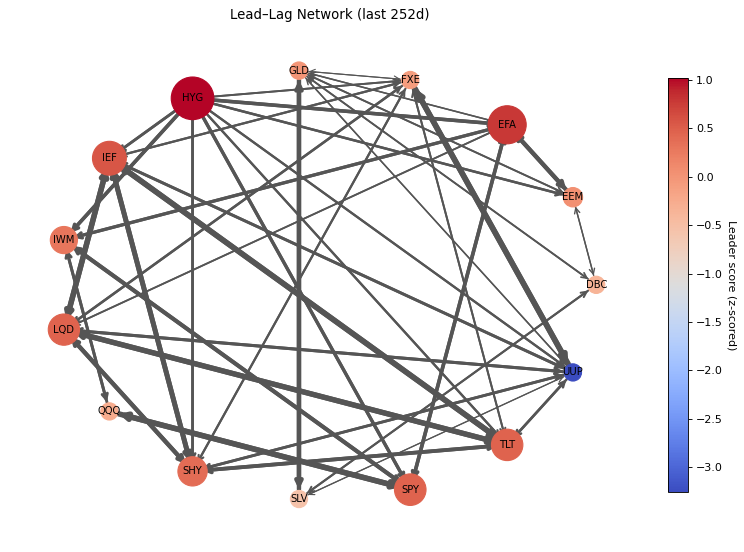

In [3]:
# Use the last 252 trading days to estimate the network
A = build_adj(returns.tail(252), max_lag=5, min_abs_corr=0.15)
H, z = leadlag_graph(
    A,
    title='Lead–Lag Network (last 252d)',
    max_edges=80,
    node_score='out_strength',
    layout='circular',
    seed=42,
    visualise=True,
)
# Top 10 leader z-scores
z.sort_values(ascending=False).head(10)


## 3) Run the network momentum backtest


In [4]:
config = BacktestConfig(leader_method="pagerank", pagerank_alpha=0.85,
    max_lag=7,
    min_abs_corr=0.10,
    sparsify_topk=5,
    regime="ma_cross", fast_ma=30, slow_ma=100,
    ema_span=20,
    target_ann_vol=0.12, cov_win=90, shrink_lambda=0.2,
    rebalance="W-FRI",
    use_numba=True,)

port_rets, metrics, w_hist = backtest_network_momentum(
    prices, returns, config
)
print(metrics)


{'CAGR': np.float64(0.09197880661097346), 'AnnVol': np.float64(0.10269786098774532), 'Sharpe': np.float64(0.8567994349898799), 'MaxDrawdown': -0.1327219309178791, 'NumTrades': 844, 'Start': '2008-04-15 00:00:00', 'End': '2024-12-31 00:00:00'}


## 4) Plot cumulative performance


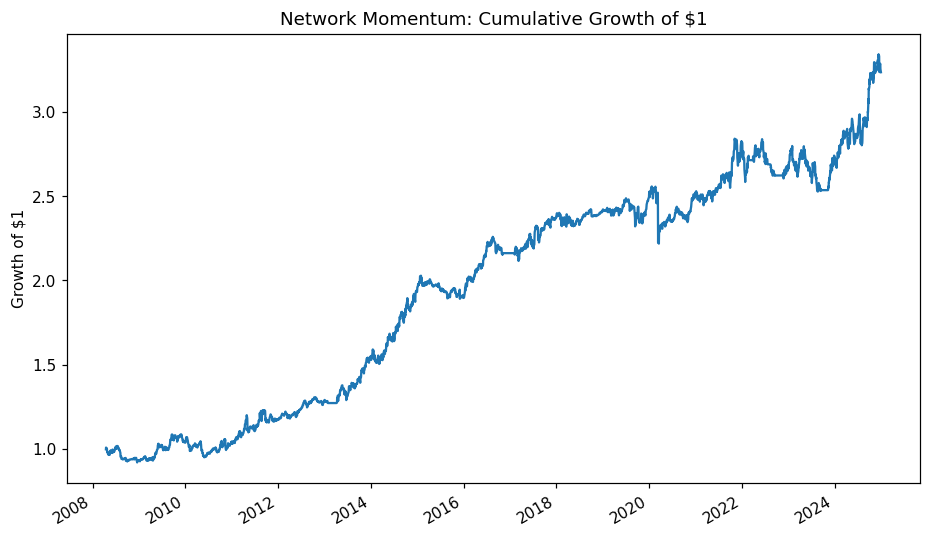

,DBC,EEM,EFA,FXE,GLD,HYG,IEF,IWM,LQD,QQQ,SHY,SLV,SPY,TLT,UUP
2024-11-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.623402,0.0,0.0,0.0,0.0,0.0
2024-12-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.644075,0.0,0.0,0.0,0.0,0.0
2024-12-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.699303,0.0,0.0,0.0,0.0,0.0
2024-12-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.686681,0.0,0.0,0.0,0.0,0.0
2024-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.695419,0.0,0.0,0.0,0.0,0.0


In [5]:
cum = port_rets.cumsum().apply(np.exp)
ax = cum.plot(title='Network Momentum: Cumulative Growth of $1')
ax.set_ylabel('Growth of $1')
plt.show()

w_hist.tail()


## 5) Validate with walk-forward

In [6]:
oos = walkforward_validation(prices, returns, config
                             )


In [7]:
sh = sharpe_ratio(oos, ann_factor=252, risk_free=0.0)
sh


np.float64(0.4529669369517187)